# Описание проекта: телекоммуникации

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание услуг

Оператор предоставляет два основных типа услуг: 
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Описание данных

Данные состоят из файлов, полученных из разных источников:
* contract_new.csv — информация о договоре;
* personal_new.csv — персональные данные клиента;
* internet_new.csv — информация об интернет-услугах;
* phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

In [3]:
%%capture

%pip install phik

import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import warnings
import numpy as np
import phik
from sklearn.model_selection import train_test_split
import datetime as dt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from catboost import CatBoostClassifier, Pool
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
import sklearn
import pickle
import xgboost as xgb
import shap

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from optuna.visualization import plot_optimization_history, plot_param_importances
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from catboost import Pool, cv
random_state = 110923
warnings.filterwarnings('ignore')

In [2]:
try:
    contract_new = pd.read_csv('/datasets/contract_new.csv')
    personal_new = pd.read_csv('/datasets/personal_new.csv')
    internet_new = pd.read_csv('/datasets/internet_new.csv')
    phone_new = pd.read_csv('/datasets/phone_new.csv')

except:
    contract_new = pd.read_csv('D:\\Yandex\\yandex-praktikum-projects\\contract_new.csv')
    personal_new = pd.read_csv('D:\\Yandex\\yandex-praktikum-projects\\personal_new.csv')
    internet_new = pd.read_csv('D:\\Yandex\\yandex-praktikum-projects\\internet_new.csv')
    phone_new = pd.read_csv('D:\\Yandex\\yandex-praktikum-projects\\phone_new.csv')

In [3]:
#создаем функцию для предварительной проверки данных
def inspect_data(df):
    print(df.head())
    print(df.isna().sum())
    print(df.describe(include = 'all'))
    print(df.info())
    print(df.duplicated().sum())
    print('_____________________________________________________________________________________________')

In [4]:
inspect_data(contract_new)
inspect_data(personal_new)
inspect_data(internet_new)
inspect_data(phone_new)

   customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  
0           Electronic check           29.85        31.04  
1               Mailed check           56.95      2071.84  
2               Mailed check           53.85       226.17  
3  Bank transfer (automatic)           42.30       1960.6  
4           Electronic check           70.70        353.5  
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64
        customerID   BeginDate

по результатам исследования, во всех датасетах отсуствуют пропущенные значения и дубликаты, 
в некоторых столбцах возможно будет необходимо изменить тип данных

In [5]:
#проверим уникальные значения столбцов для датасета contract_new
for column in contract_new.columns:
    print('{}:\n{}'.format(column, np.sort(contract_new[column].unique())))

customerID:
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
BeginDate:
['2013-10-01' '2013-11-01' '2013-12-01' '2014-01-01' '2014-02-01'
 '2014-03-01' '2014-04-01' '2014-05-01' '2014-06-01' '2014-07-01'
 '2014-08-01' '2014-09-01' '2014-10-01' '2014-11-01' '2014-12-01'
 '2015-01-01' '2015-02-01' '2015-03-01' '2015-04-01' '2015-05-01'
 '2015-06-01' '2015-07-01' '2015-08-01' '2015-09-01' '2015-10-01'
 '2015-11-01' '2015-12-01' '2016-01-01' '2016-02-01' '2016-03-01'
 '2016-04-01' '2016-05-01' '2016-06-01' '2016-07-01' '2016-08-01'
 '2016-09-01' '2016-10-01' '2016-11-01' '2016-12-01' '2017-01-01'
 '2017-02-01' '2017-03-01' '2017-04-01' '2017-05-01' '2017-06-01'
 '2017-07-01' '2017-08-01' '2017-09-01' '2017-10-01' '2017-11-01'
 '2017-12-01' '2018-01-01' '2018-02-01' '2018-03-01' '2018-04-01'
 '2018-05-01' '2018-06-01' '2018-07-01' '2018-08-01' '2018-09-01'
 '2018-10-01' '2018-11-01' '2018-12-01' '2019-01-01' '2019-02-01'
 '2019-03-01' '2019-04-01' '2019-0

In [6]:
#посмотрим на столбец TotalCharges значения ' '
print(contract_new.loc[contract_new['TotalCharges'] == ' ', :])

      customerID   BeginDate EndDate      Type PaperlessBilling  \
488   4472-LVYGI  2020-02-01      No  Two year              Yes   
753   3115-CZMZD  2020-02-01      No  Two year               No   
936   5709-LVOEQ  2020-02-01      No  Two year               No   
1082  4367-NUYAO  2020-02-01      No  Two year               No   
1340  1371-DWPAZ  2020-02-01      No  Two year               No   
3331  7644-OMVMY  2020-02-01      No  Two year               No   
3826  3213-VVOLG  2020-02-01      No  Two year               No   
4380  2520-SGTTA  2020-02-01      No  Two year               No   
5218  2923-ARZLG  2020-02-01      No  One year              Yes   
6670  4075-WKNIU  2020-02-01      No  Two year               No   
6754  2775-SEFEE  2020-02-01      No  Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges  
488   Bank transfer (automatic)           52.55               
753                Mailed check           20.25               
936   

вероятно это новые клиенты, заменим эти значения на ноль

In [7]:
contract_new.loc[contract_new['TotalCharges'] == ' ', 'TotalCharges'] = 0

In [8]:
#проверим уникальные значения столбцов для датасета personal_new
for column in personal_new.columns:
    print('{}:\n{}'.format(column, np.sort(personal_new[column].unique())))

customerID:
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
gender:
['Female' 'Male']
SeniorCitizen:
[0 1]
Partner:
['No' 'Yes']
Dependents:
['No' 'Yes']


In [9]:
# приведем столбец SeniorCitizen к однообразному виду
personal_new['SeniorCitizen'].replace({0:'No', 1:'Yes'}, inplace=True)

In [10]:
#проверим уникальные значения столбцов для датасета internet_new
for column in internet_new.columns:
    print('{}:\n{}'.format(column, np.sort(internet_new[column].unique())))

customerID:
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
InternetService:
['DSL' 'Fiber optic']
OnlineSecurity:
['No' 'Yes']
OnlineBackup:
['No' 'Yes']
DeviceProtection:
['No' 'Yes']
TechSupport:
['No' 'Yes']
StreamingTV:
['No' 'Yes']
StreamingMovies:
['No' 'Yes']


In [11]:
#проверим уникальные значения столбцов для датасета phone_new
for column in phone_new.columns:
    print('{}:\n{}'.format(column, np.sort(phone_new[column].unique())))

customerID:
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-RRAMN' '9992-UJOEL'
 '9993-LHIEB']
MultipleLines:
['No' 'Yes']


In [12]:
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [13]:
#изменим тип данных в столбцах BeginDate, TotalCharges
contract_new['BeginDate'] = pd.to_datetime(contract_new['BeginDate'], format='%Y-%m-%dT%H:%M:%S')
contract_new['TotalCharges'] = contract_new['TotalCharges'].astype('float')

In [14]:
#объединим таблицы personal_new, contract_new, , internet_new, phone_new
df = contract_new.merge(personal_new, on='customerID', how='left')
df = df.merge(internet_new, on='customerID', how='left')
df = df.merge(phone_new, on='customerID', how='left')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   object        
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

после объединения есть отсуствующие значения, заменим их на 'no', это значит что этими услугами клиенты не воспользовались

In [16]:
for replacement in ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                    'TechSupport','StreamingTV','StreamingMovies', 'MultipleLines']:
    df[replacement] = df[replacement].fillna('No')

In [17]:
#добавим столбец churn с инфой по ушедшим клиетам
df.loc[df['EndDate'] != 'No', 'churn'] = 'leave'
df.loc[df['EndDate'] == 'No', 'churn'] = 'stay'

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   object        
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

на данном этапе обработаны аномалии и пропущенные значения, изменены типы данных, объеденены таблицы

In [19]:
#выявим корреляцию признаков
df.corr(numeric_only=True)

MonthlyCharges  TotalCharges
MonthlyCharges         1.00000       0.63044
TotalCharges           0.63044       1.00000

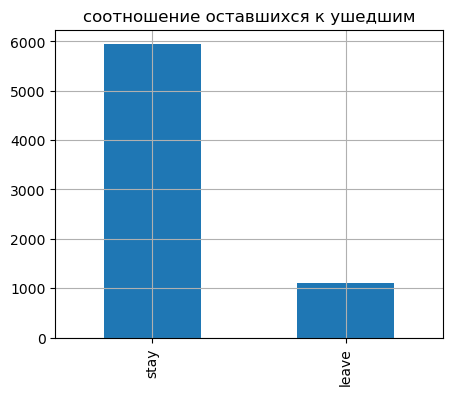

In [20]:
df['churn'].value_counts().plot(kind='bar', grid=True,figsize=(5,4),title='cоотношение оставшихся к ушедшим');

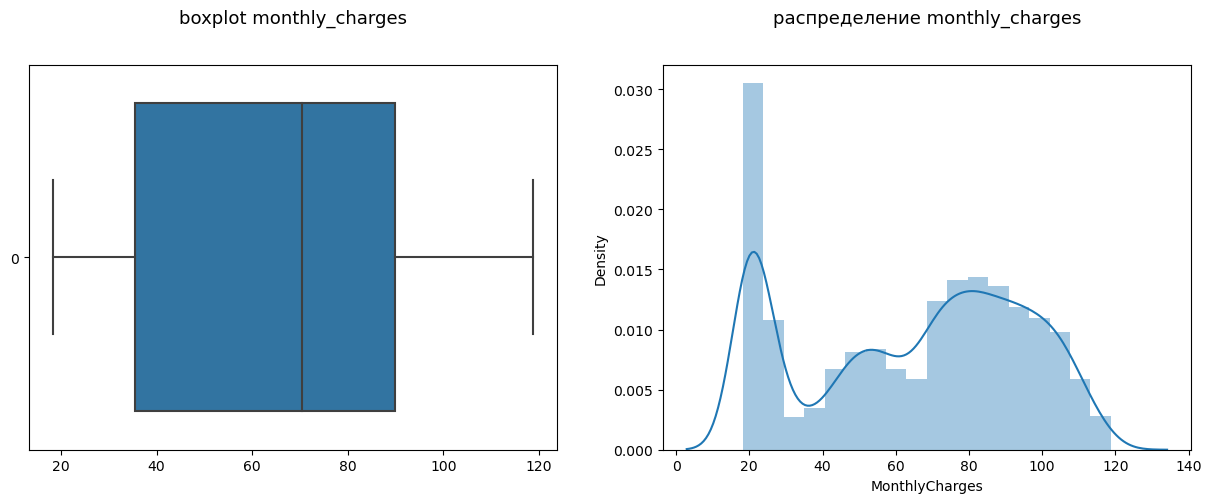

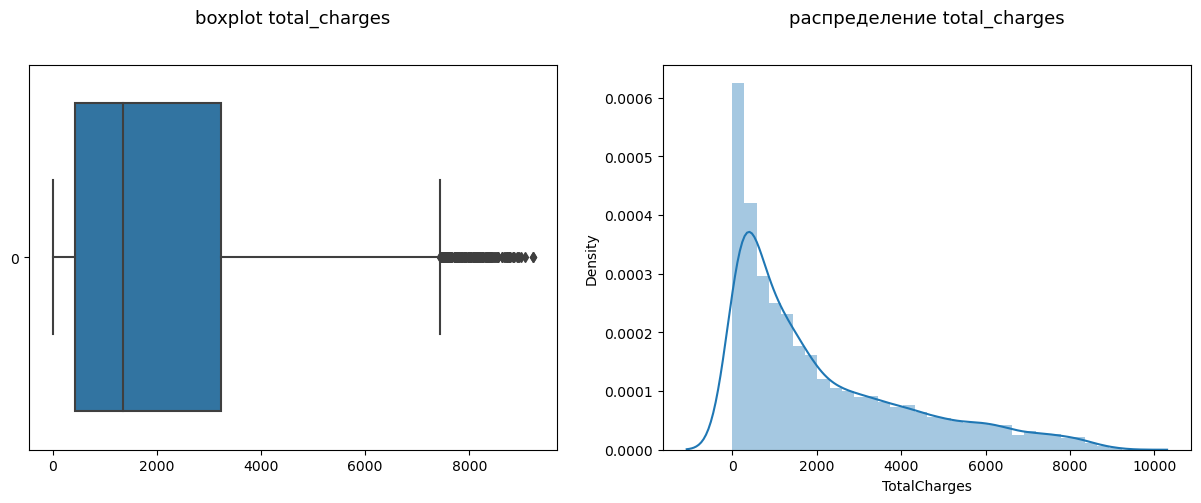

In [21]:
#проверим на выбросы и распределения
monthly = df['MonthlyCharges']

fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.set_title('boxplot monthly_charges', size=13, pad=30)
ax2.set_title('распределение monthly_charges', size=13, pad=30)
sns.boxplot(monthly, ax=ax1, orient='h')
sns.distplot(monthly, ax=ax2)
plt.show()

total = df['TotalCharges']

fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.set_title('boxplot total_charges', size=13, pad=30)
ax2.set_title('распределение total_charges', size=13, pad=30)
sns.boxplot(total, ax=ax1, orient='h')
sns.distplot(total, ax=ax2)
plt.show()

In [22]:
df['TotalCharges'].describe().count()

8

In [23]:
#создадим списки столбцов для изучения срезов данных
a_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
b_cols = ['Type', 'PaperlessBilling', 'PaymentMethod']
c_cols = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection']
d_cols = ['TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

проверим распределение клиентов по категориям

In [24]:
#создадим функцию для вывода соотношений
def pivot_p(table, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    for ax, column in zip(axes.ravel(), columns):
        data = (df[column].value_counts()/len(df)).to_frame().reset_index()
        sns.barplot(y=data.columns[1], x='index', data=data, ax=ax)
        ax.set_xticklabels(ax.get_xticklabels())
        ax.set(ylabel=None, xlabel=None)
        ax.set_title(f'{column}')
        
        for p in ax.patches:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy()
            ax.annotate(f'{height:.0%}', (x+width/2, y+height*1.02))
 
    plt.tight_layout()
    plt.show()
    return

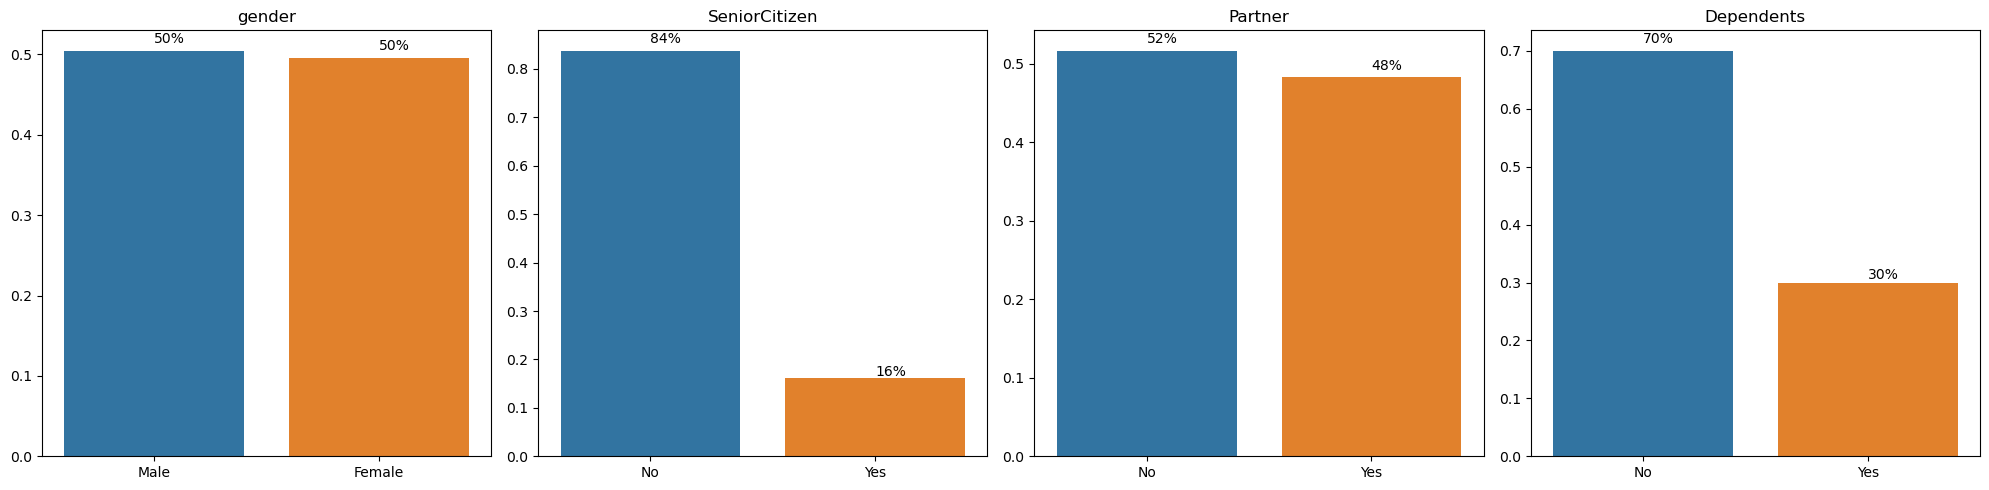

In [25]:
pivot_p(df, a_cols)

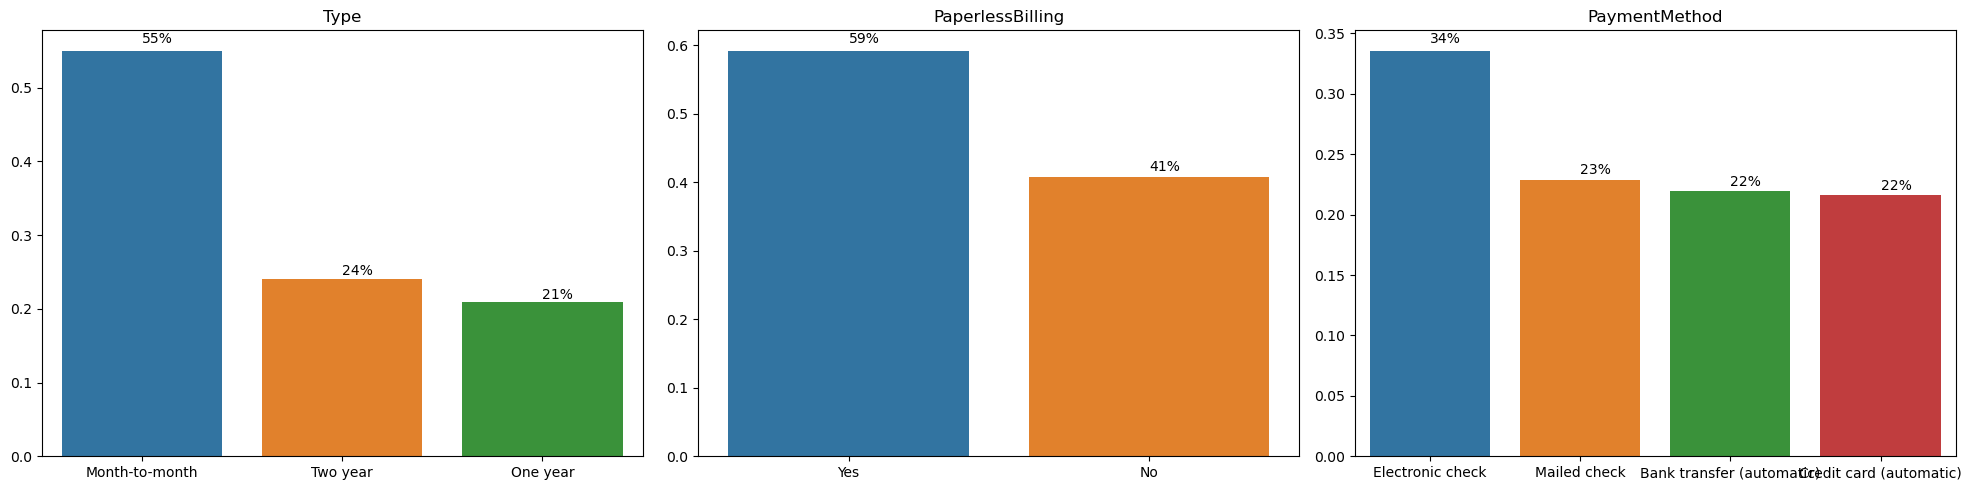

In [26]:
pivot_p(df, b_cols)

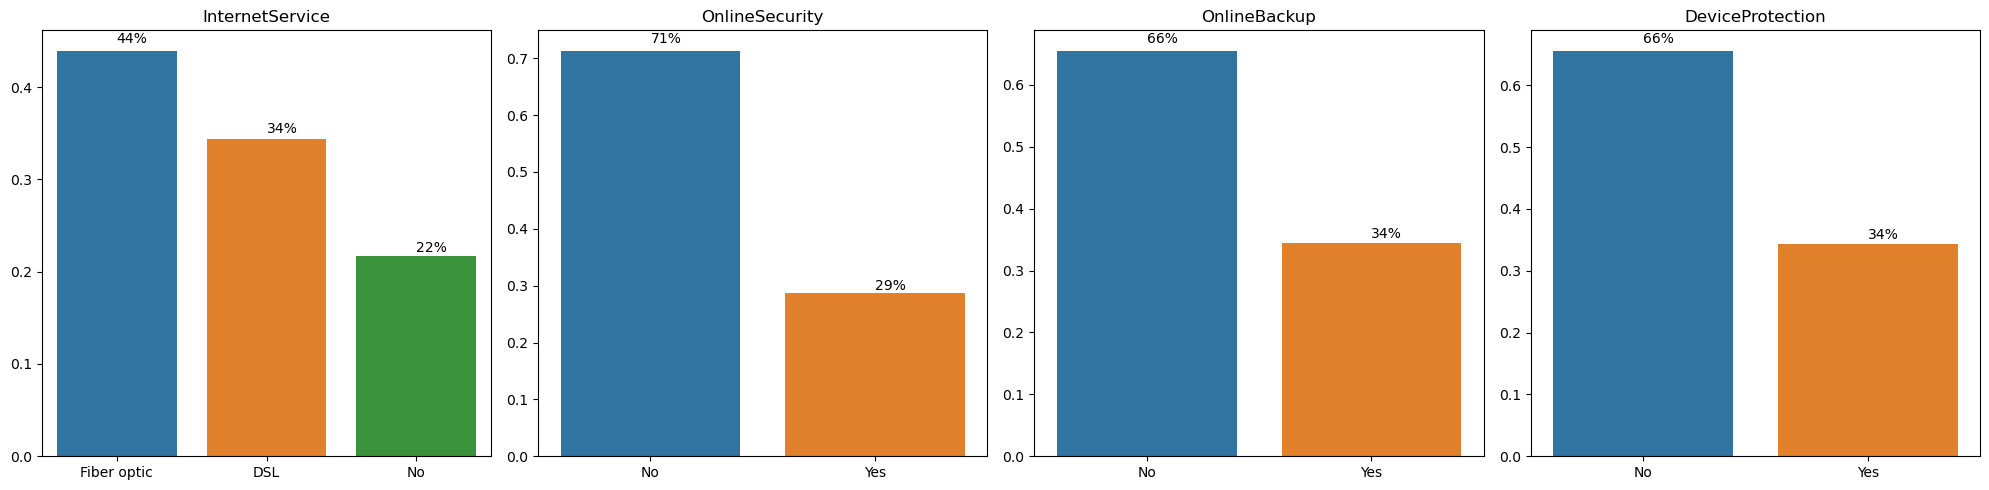

In [27]:
pivot_p(df, c_cols)

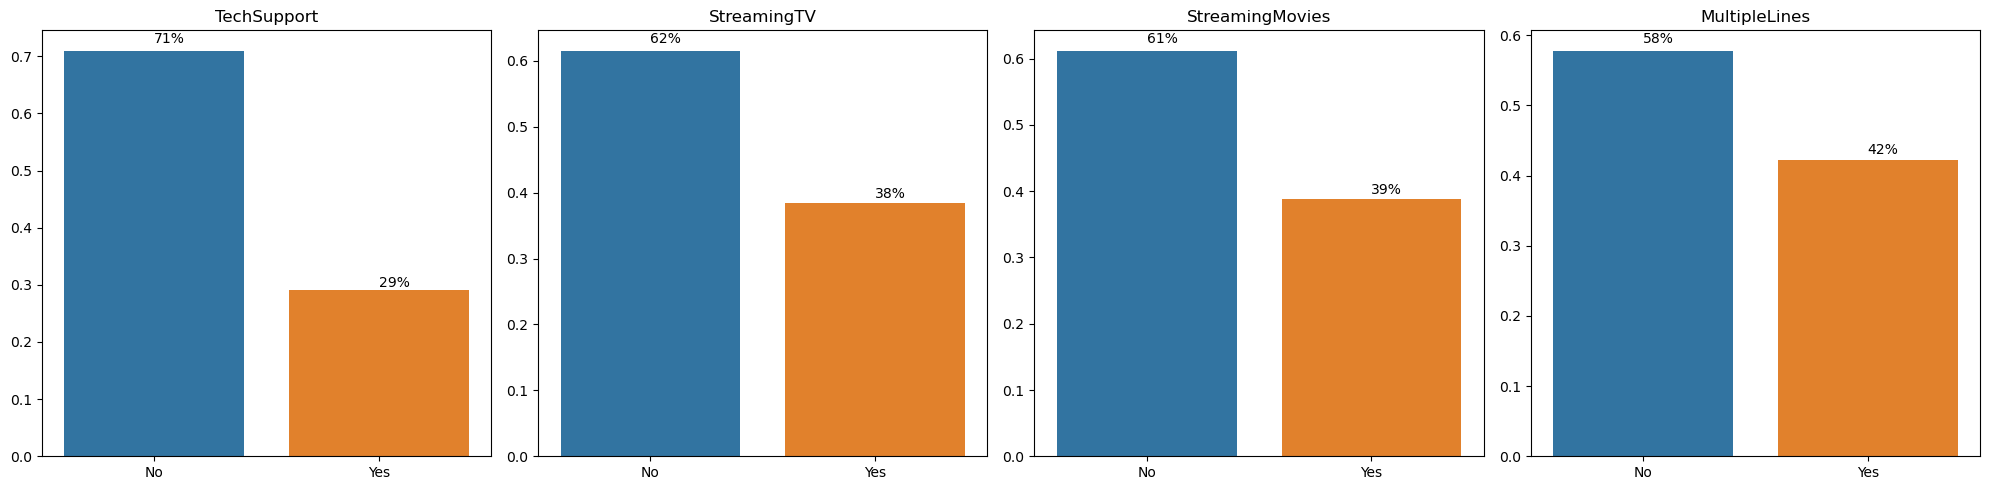

In [28]:
pivot_p(df, d_cols)

проверим распределение по оттоку

In [29]:
#создадим функцию для анализа оттока
def pivot_l(table, columns):   
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    for ax, column in zip(axes.ravel(), columns):
        data = df.groupby(['churn', column])[column].count().groupby(column).apply(lambda x: 100 * x/x.sum())\
        .to_frame().stack().reset_index()
        sns.barplot(x=column, y=0, hue='churn', data=data, ax=ax)
        ax.set_xticklabels(ax.get_xticklabels())
        ax.set(ylabel=None, xlabel=None)
        ax.set_title(f'{column}')

        for p in ax.patches:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy()
            ax.annotate(f'{height/100:.0%}', (x+width/2, y+height*1.02))
    plt.tight_layout()
    plt.show()

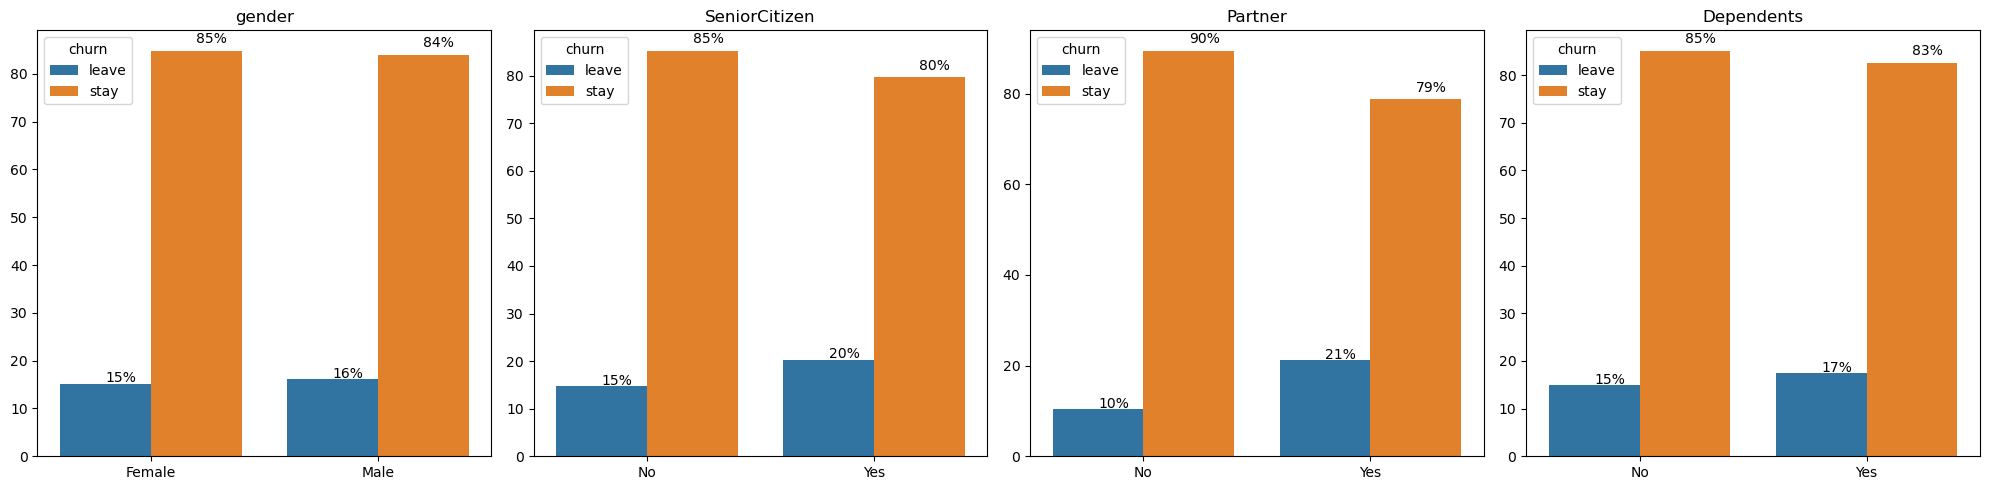

In [30]:
pivot_l(df, a_cols)

по результатом исследования, отток клиентов мужчин и женщин почти одинаковый, среди пожилых выше, у семейных пар отток немного выше, и у клиентов с иждевенцами тоже немного выше

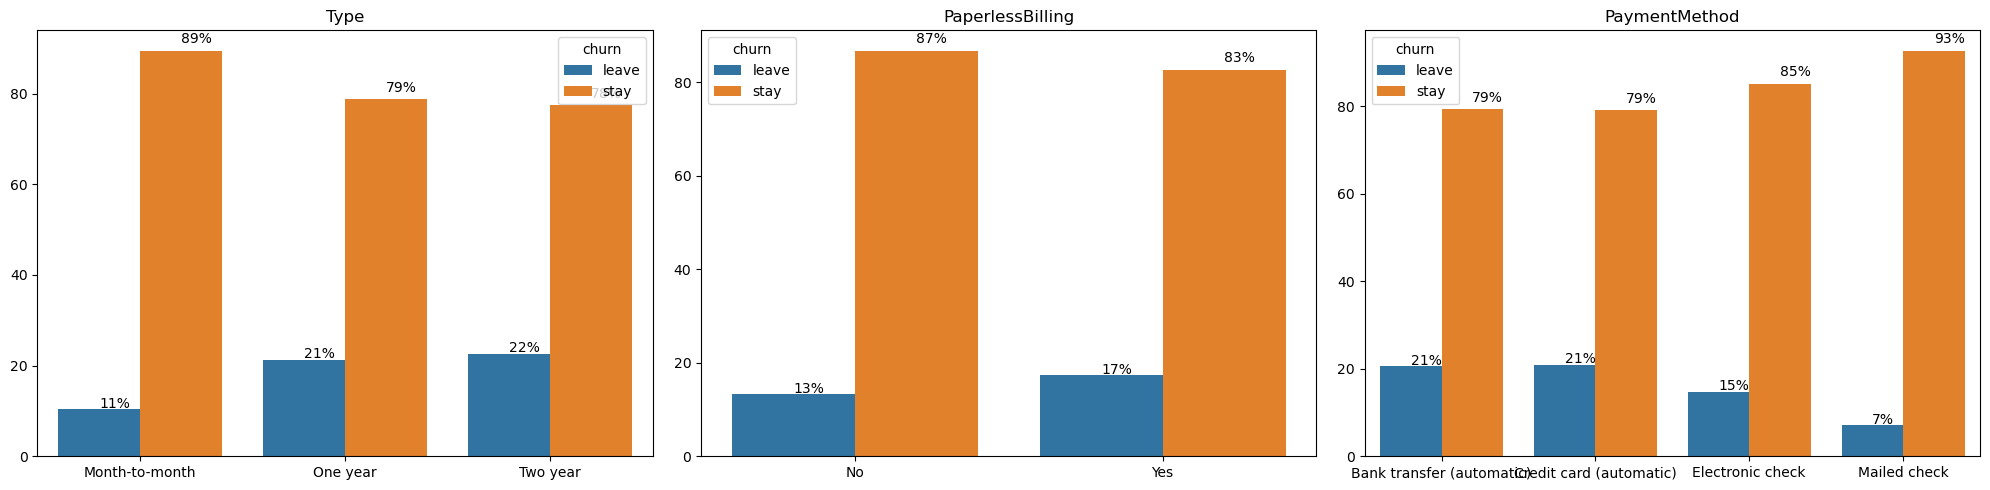

In [31]:
pivot_l(df, b_cols)

по результатам исследования, отток гораздо выше у клиентов с одно и двух летними котрактами, а также выше у клиентов предпочитающих бумажный биллинг, и выше у клиентов использующих банковский перевод или кредитную карту

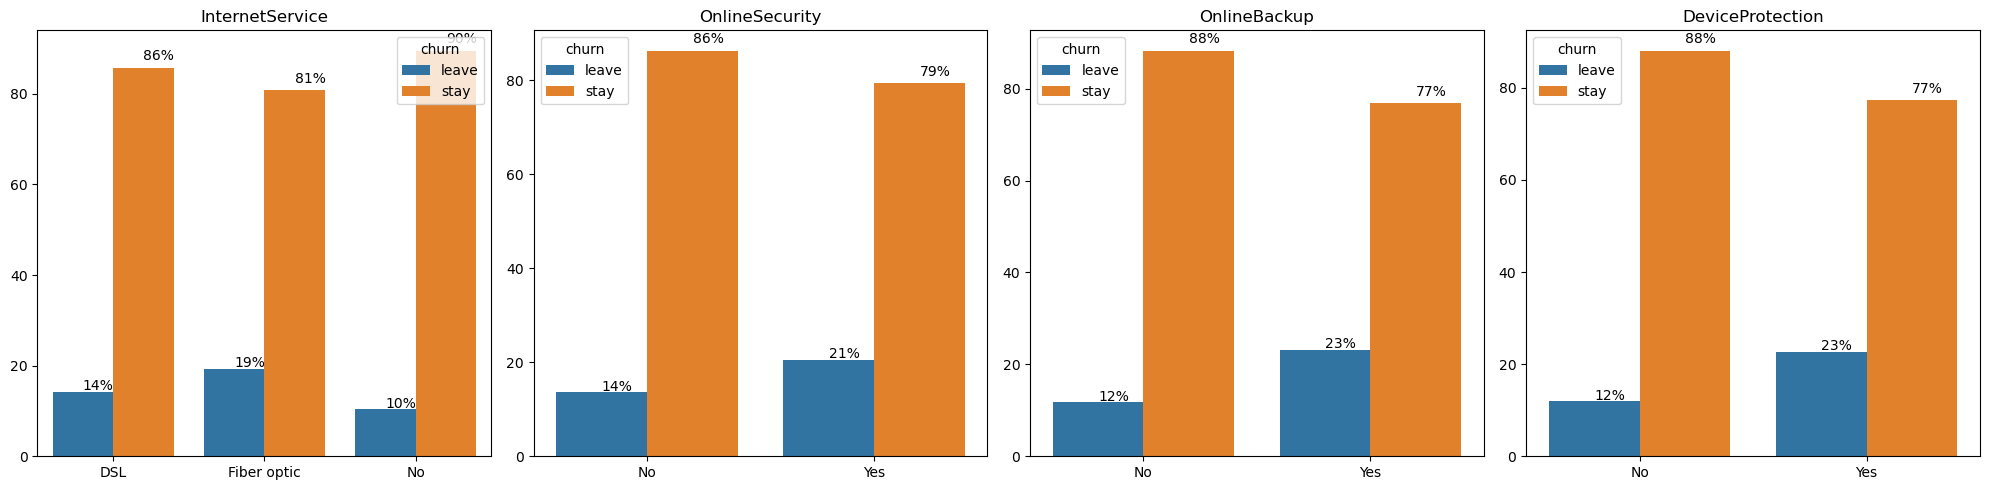

In [32]:
pivot_l(df, c_cols)

по результатам исследования, наиболее вероятный отток с типом подключения Fiber optic, за ним DSL, и те кто не пользуется интернетом, а также у клиентов с подключенной услугами OnlineSecurity, OnlineBackup, и DeviceProtection

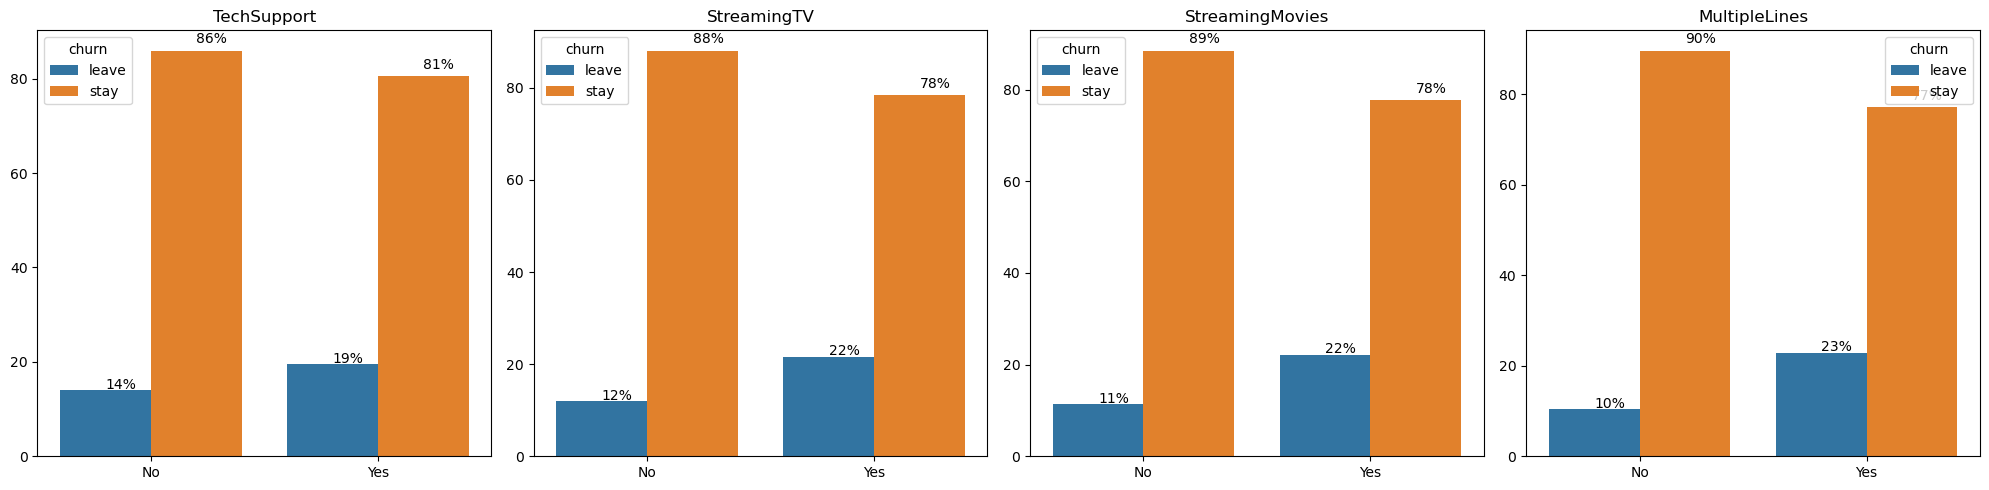

In [33]:
pivot_l(df, d_cols)

по результатам исследования, отток клиентов использующих услугу TechSupport выше, аналогичная ситуация по услугам StreamingTV, StreamingMovies, и MultipleLines

In [34]:
income_comp = df.pivot_table(index=['Type'], values=['MonthlyCharges', 'TotalCharges'], aggfunc='sum').reset_index()
display(income_comp)

Type  MonthlyCharges  TotalCharges
0  Month-to-month       257294.15    5143598.92
1        One year        95816.60    4042702.38
2        Two year       103005.85    5711847.35

In [35]:
#создадим списки числовых и категориальных признаков
categorical = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
               'Type', 'PaperlessBilling', 'PaymentMethod',
               'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
 
numeric = ['MonthlyCharges', 'TotalCharges']

In [36]:
#закодируем признаки
enc = OneHotEncoder(handle_unknown='error', drop='first')
enc.fit(df[categorical])
df_cat = pd.DataFrame(
    enc.fit_transform(df[categorical]).toarray(),
    columns=enc.get_feature_names_out(categorical),
    index=df.index)

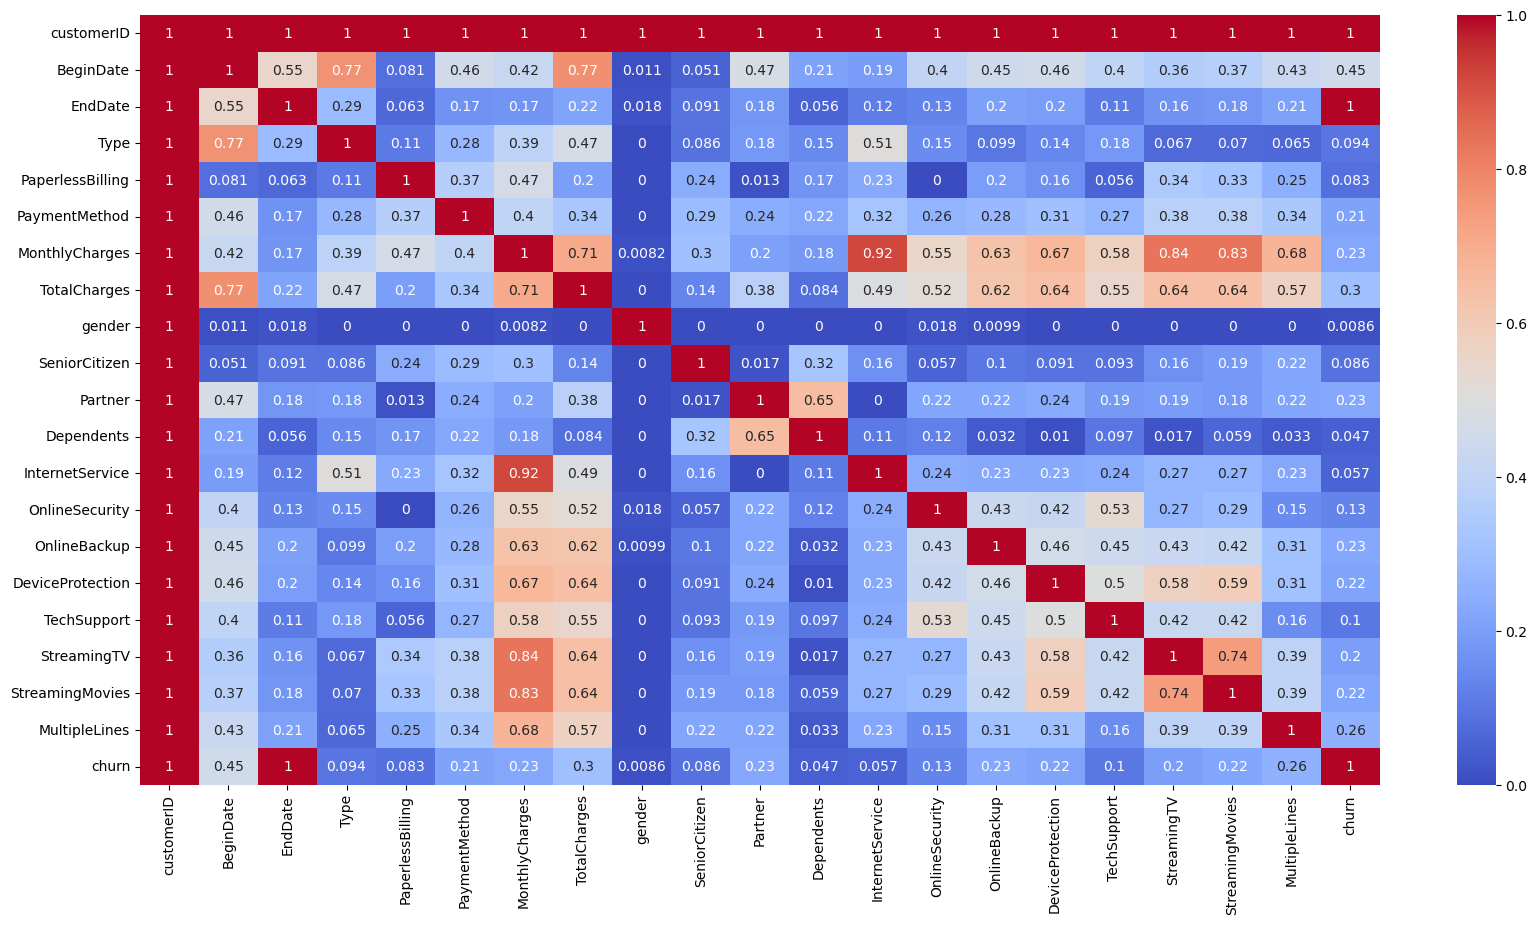

In [37]:
#проверим корреляцию признаков
corr_m = df.phik_matrix(interval_cols=numeric)
plt.figure(figsize=(20, 10))
sns.heatmap(corr_m, annot=True, cmap='coolwarm');

# Вывод

по результатам исследования, выявлена выявлены следующие зависимости признаков:

ежемесячные платежи, стриминг фильмы и тв, интернет услуги, телефония, общая стоимость услуг, семейные пары и иждевенцы, 
тип контракта и интернет услуги



есть дисбаланс классов в пользу отсавшихся клиентов

большое количество клиентов с небольшими платежами, с большими общими платежами в разы меньше

при изучении срезов данных выяснили что отток клиентов мужчин и женщин почти одинаковый, среди пожилых выше, у семейных пар отток немного выше, и у клиентов с иждевенцами тоже немного выше

гораздо выше у клиентов с одно и двух летними котрактами, а также выше у клиентов предпочитающих бумажный биллинг, и выше у клиентов использующих банковский перевод или кредитную карту

по результатам исследования, наиболее вероятный отток с типом подключения Fiber optic, за ним DSL, и те кто не пользуется интернетом, а также у клиентов с подключенной услугами OnlineSecurity, OnlineBackup, и DeviceProtection

по результатам исследования, отток клиентов использующих услугу TechSupport выше, аналогичная ситуация по услугам StreamingTV, StreamingMovies, и MultipleLines

* Примерный план решения задачи:

предобработка данных, проверка на аномалии и дубликаты, приведение типов данных в соотвествии с содержанием

предварительный анализ данных, включая описание признаков, статистические характеристики и визуализацию распределений

исследование взаимосвязей между признаками

поздание признаков для использования в модели

выбор, подбор параметров модели, и обучение модели 

оценка качества модели на тестовой выборке

интерпретация результатов и формулирование выводов

* Цель проекта: 

спрогнозировать отток клиентов, используя персональные данные клиентов и информацию об услугах

In [38]:
#добавим признак жизни клиентов в днях
df['EndDate'] = np.where(df.EndDate == 'No', dt.date(2020, 2, 1), df['EndDate'])
df['BeginDate'] = pd.to_datetime(df.BeginDate, format='%Y/%m/%d')
df['EndDate'] = pd.to_datetime(df.EndDate, format='%Y/%m/%d')
df['lifetime'] = (df['EndDate'] - df['BeginDate']).dt.days

In [39]:
#удалим не нужные признаки
df = df.drop(['customerID', 'BeginDate', 'EndDate'], axis=1) 

In [40]:
df.loc[df['churn'] == 'leave', 'churn'] = 0
df.loc[df['churn'] == 'stay', 'churn'] = 1

In [41]:
df['churn'] = df['churn'].astype('int')

In [42]:
df.head()

Type PaperlessBilling              PaymentMethod  MonthlyCharges  \
0  Month-to-month              Yes           Electronic check           29.85   
1        One year               No               Mailed check           56.95   
2  Month-to-month              Yes               Mailed check           53.85   
3        One year               No  Bank transfer (automatic)           42.30   
4  Month-to-month              Yes           Electronic check           70.70   

   TotalCharges  gender SeniorCitizen Partner Dependents InternetService  \
0         31.04  Female            No     Yes         No             DSL   
1       2071.84    Male            No      No         No             DSL   
2        226.17    Male            No      No         No             DSL   
3       1960.60    Male            No      No         No             DSL   
4        353.50  Female            No      No         No     Fiber optic   

  OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
0             No          Yes               No          No          No   
1            Yes           No              Yes          No          No   
2            Yes          Yes               No          No          No   
3            Yes           No              Yes         Yes          No   
4             No           No               No          No          No   

  StreamingMovies MultipleLines  churn  lifetime  
0              No            No      1        31  
1              No            No      1      1036  
2              No            No      1       123  
3              No            No      1      1371  
4              No            No      1       153

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   gender            7043 non-null   object 
 6   SeniorCitizen     7043 non-null   object 
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  MultipleLines     7043 non-null   object 


In [48]:
#обновим списки числовых и категориальных признаков
num_cols = ['lifetime', 'MonthlyCharges', 'TotalCharges']

cat_cols = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen',
            'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'lifetime']

In [49]:
#подготовим набор признаков
X = df.drop(['churn'], axis=1)
y = df['churn']

In [50]:
#делим данные на две выборки: тренировочную и тестовую 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=random_state)

In [51]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale',StandardScaler())
])
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [52]:
col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline,num_cols),
    ('cat_pipeline',cat_pipeline,cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

## Обучение моделей

## CatBoost

In [53]:
train_pool = Pool(X_train, y_train, cat_features=cat_cols)

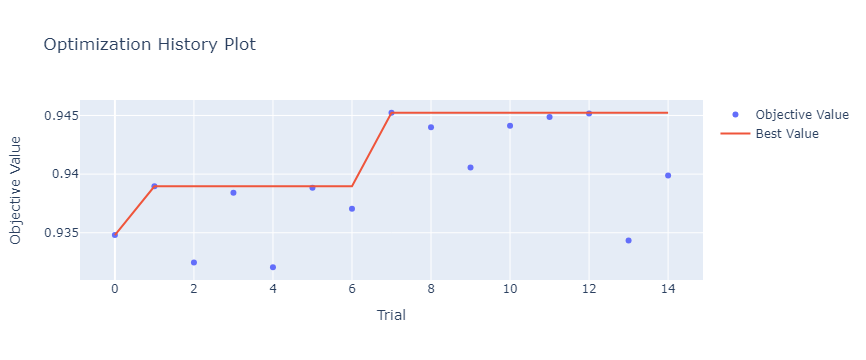

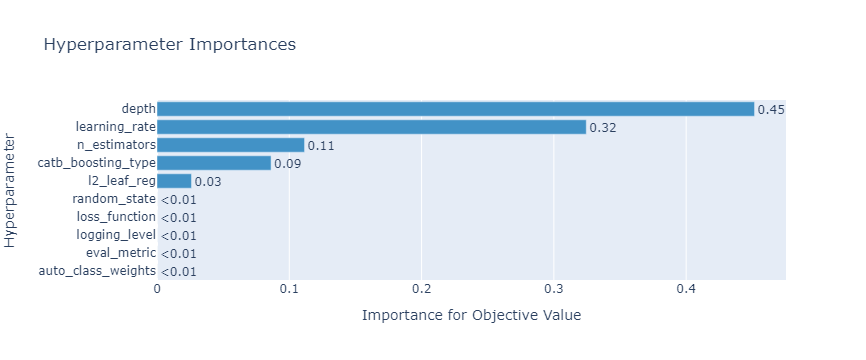

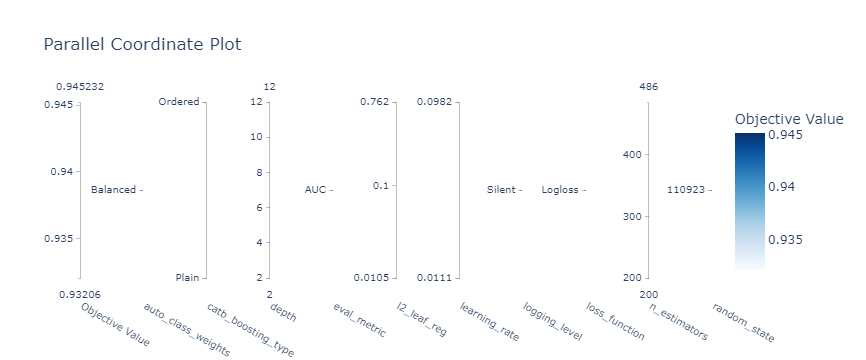

количество завершенных испытаний: 15
лучшее испытание:
  метрика AUC-ROC: 0.9452322182020074
  параметры: 
    eval_metric: AUC
    n_estimators: 406
    loss_function: Logloss
    random_state: 110923
    learning_rate: 0.04085149160088907
    l2_leaf_reg: 0.021208510351041734
    depth: 2
    logging_level: Silent
    catb_boosting_type: Plain
    auto_class_weights: Balanced


In [55]:
def objective(trial):
    global train_pool

    param = {        
        'eval_metric': trial.suggest_categorical('eval_metric', ['AUC']),
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'loss_function': trial.suggest_categorical('loss_function', ['Logloss']),
        'random_state': trial.suggest_categorical('random_state', [random_state]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.01, 1.0),
        'depth': trial.suggest_int('depth', 2, 12),
        'logging_level': trial.suggest_categorical('logging_level', ['Silent']),
        'boosting_type': trial.suggest_categorical('catb_boosting_type', ['Plain', 'Ordered']),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced']),
    }
    
    model = CatBoostClassifier(**param)
    model.fit(train_pool)
    
    with open("{}.pickle".format(trial.number), 'wb') as fout:
        pickle.dump(model, fout)
        
    scores = cv(train_pool, param, fold_count=4)

    return scores['test-AUC-mean'].values[-1]       

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

fig_list = [
        optuna.visualization.plot_optimization_history(study),
        optuna.visualization.plot_param_importances(study),
        optuna.visualization.plot_parallel_coordinate(study),
    ]
for fig in fig_list:
    fig.update_layout(width=1000)
    fig.show()
    
print('количество завершенных испытаний: {}'.format(len(study.trials)))
print('лучшее испытание:')
trial = study.best_trial

print('  метрика AUC-ROC: {}'.format(trial.value))

print('  параметры: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))
    
with open("{}.pickle".format(study.best_trial.number), 'rb') as fin:
    best_cb = pickle.load(fin)

## XGB

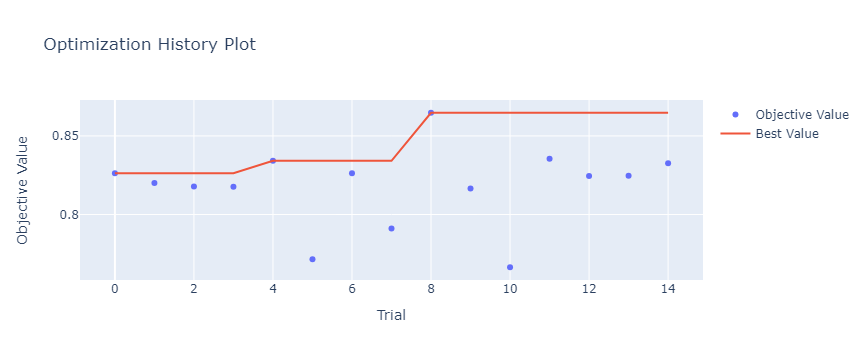

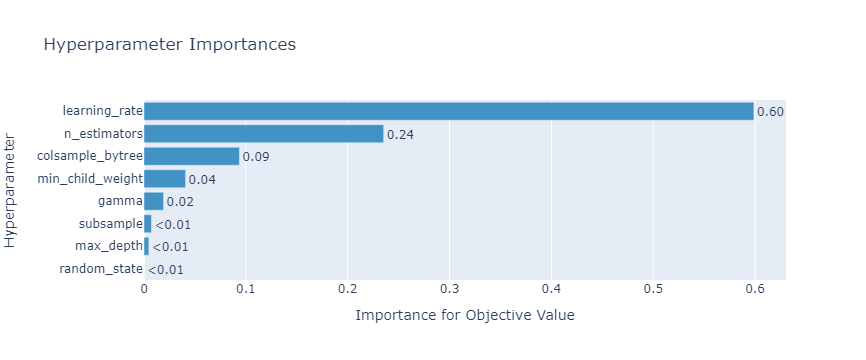

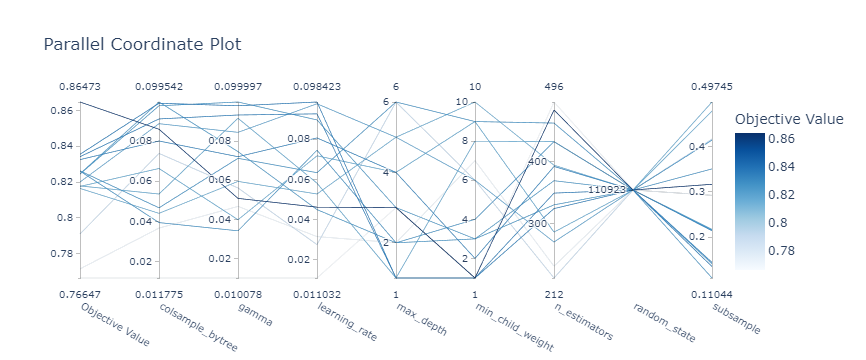

количество завершенных испытаний: 15
лучшее испытание:
  метрика AUC-ROC: 0.8647257695689234
  параметры: 
    n_estimators: 483
    max_depth: 3
    learning_rate: 0.046213016507357395
    random_state: 110923
    colsample_bytree: 0.0859584064332088
    min_child_weight: 1
    gamma: 0.050749680319541336
    subsample: 0.31651800902241867


In [59]:
def objective(trial):

    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'random_state': trial.suggest_categorical('random_state', [random_state]),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 0.1),
        'min_child_weight':trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.1, 0.5),
        }
    
    model = XGBClassifier(**param)
    pipe = Pipeline(steps=[('col_trans', col_trans), ('model', model)])
    pipe.fit(X_train, y_train)
    
    with open("{}.pickle".format(trial.number), 'wb') as fout:
        pickle.dump(model, fout)
    
    score = cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

fig_list = [
        optuna.visualization.plot_optimization_history(study),
        optuna.visualization.plot_param_importances(study),
        optuna.visualization.plot_parallel_coordinate(study),
    ]
for fig in fig_list:
    fig.update_layout(width=1000)
    fig.show()
    
print('количество завершенных испытаний: {}'.format(len(study.trials)))
print('лучшее испытание:')
trial = study.best_trial

print('  метрика AUC-ROC: {}'.format(trial.value))

print('  параметры: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))
    
with open("{}.pickle".format(study.best_trial.number), 'rb') as fin:
    best_xgb = pickle.load(fin)

## LGBM

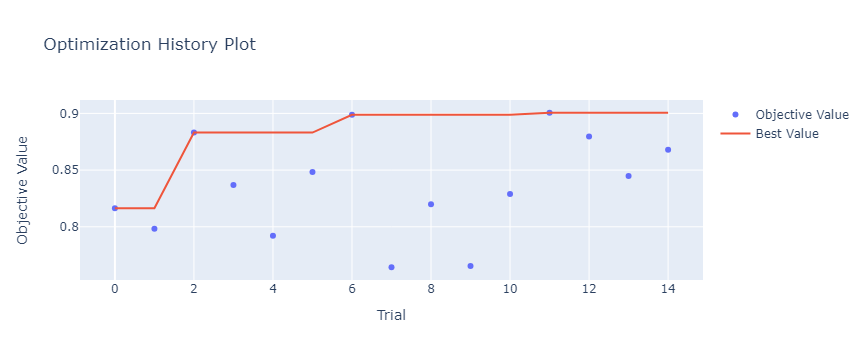

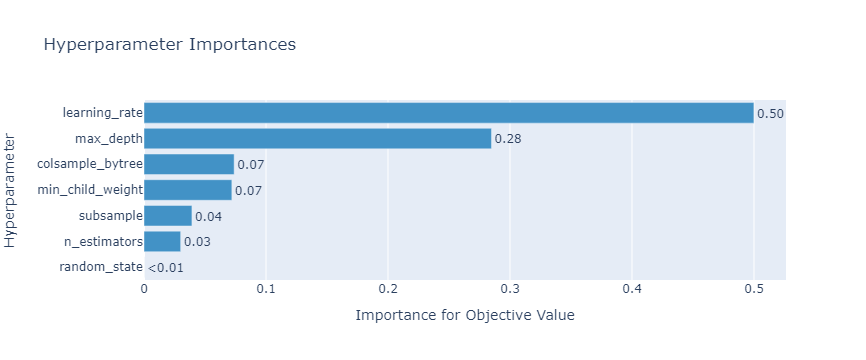

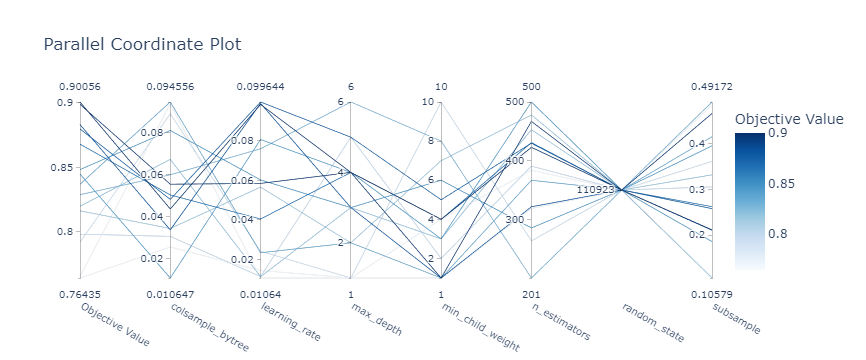

количество завершенных испытаний: 15
лучшее испытание:
  метрика AUC-ROC: 0.9005635213882762
  параметры: 
    n_estimators: 423
    max_depth: 4
    learning_rate: 0.0984113819643577
    random_state: 110923
    colsample_bytree: 0.0435478807575979
    min_child_weight: 4
    subsample: 0.21134888522345202


In [60]:
def objective(trial):

    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'random_state': trial.suggest_categorical('random_state', [random_state]),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 0.1),
        'min_child_weight':trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 0.5),
        }
    
    model = LGBMClassifier(**param)
    pipe = Pipeline(steps=[('col_trans', col_trans), ('model', model)])
    pipe.fit(X_train, y_train)
    
    with open("{}.pickle".format(trial.number), 'wb') as fout:
        pickle.dump(model, fout)
    
    score = cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

fig_list = [
        optuna.visualization.plot_optimization_history(study),
        optuna.visualization.plot_param_importances(study),
        optuna.visualization.plot_parallel_coordinate(study),
    ]
for fig in fig_list:
    fig.update_layout(width=1000)
    fig.show()
    
print('количество завершенных испытаний: {}'.format(len(study.trials)))
print('лучшее испытание:')
trial = study.best_trial

print('  метрика AUC-ROC: {}'.format(trial.value))

print('  параметры: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))
    
with open("{}.pickle".format(study.best_trial.number), 'rb') as fin:
    best_lgb = pickle.load(fin)

лучшая метрика получилась на модели catboost, далее будем проверять ее на тесте

In [57]:
proba_cb = best_cb.predict_proba(X_test)[:,1]
roc_auc_cb = roc_auc_score(y_test, proba_cb)

print('ROC-AUC:', roc_auc_cb)

ROC-AUC: 0.9504562922559051


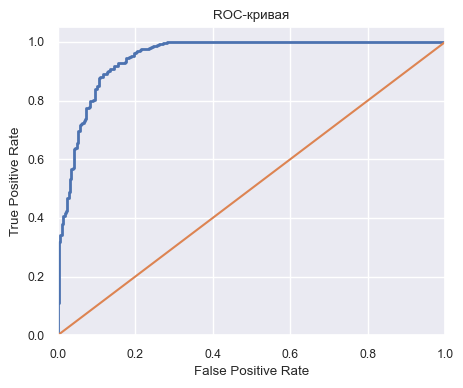

In [147]:
sns.set(font_scale=0.8)
fpr, tpr, thresholds = roc_curve(y_test, proba_cb)

plt.figure(figsize=(5, 4))
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

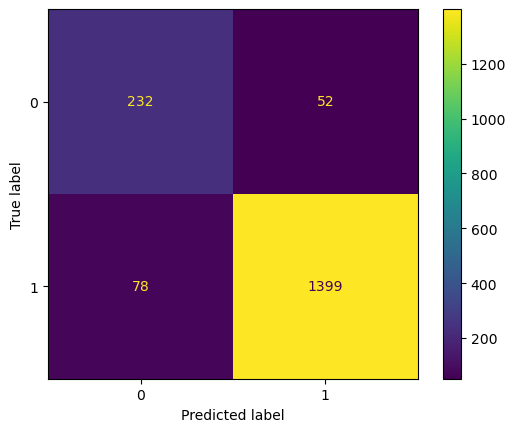

In [100]:
predictions = best_cb.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=best_cb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=best_cb.classes_)

disp.plot()
plt.show();

матрица неточностей показывает оптимистический настрой модели

## SHAP

построим график элементы наиболее важных для модели значений, чтобы показать распределение влияния каждого объекта на выходные данные

In [108]:
explainer = shap.TreeExplainer(best_cb)
shap_values_train = explainer.shap_values(Pool(X_train, y_train, cat_features=cat_cols))
shap_values_test = explainer.shap_values(Pool(X_test, y_test, cat_features=cat_cols))

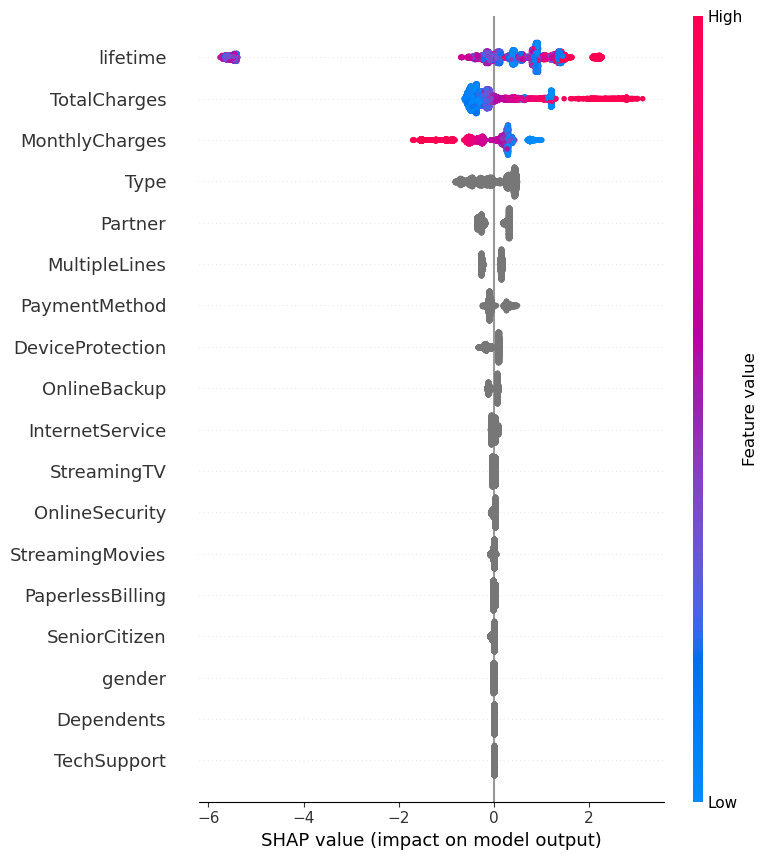

In [112]:
#оценим влияние признаков
shap.summary_plot(shap_values_train, X_train)

построим сводный график зависимости формы, чтобы показать влияние одного объекта на весь набор данных

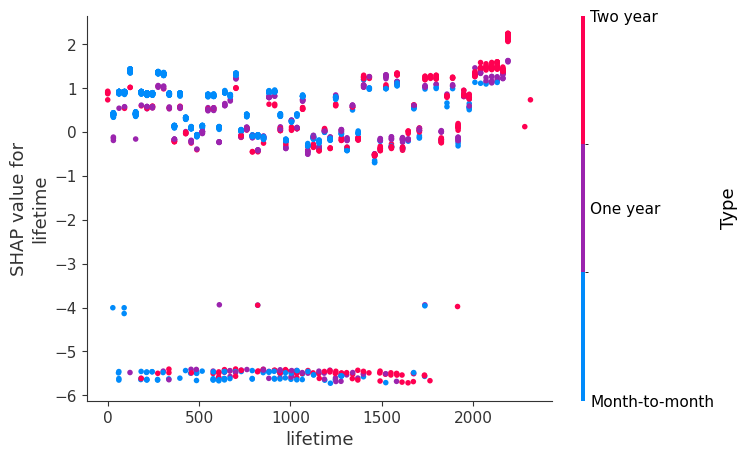

In [110]:
#создадим график зависимости формы
shap.dependence_plot('lifetime', shap_values_test, X_test)

из графика зависимости видно, что у клиентов с ежемесячным контрактом вероятность оттока выше, чем у клиентов с двухлетним контрактом, т.е. более высокие значения срока жизни клиента снижают вероятность оттока

далее мы можем проанализировать влияние отдельных признаков на предсказания для каждого конкретного объекта

## Отчет

* следующие пункты плана были выполнены без изменений:

* предобработка данных, проверка на аномалии и дубликаты, приведение типов данных в соотвествии с содержанием

* предварительный анализ данных, включая описание признаков, статистические характеристики и визуализацию распределений

* исследование взаимосвязей между признаками

* создание признаков для использования в модели

* выбор, подбор параметров модели, и обучение модели

* оценка качества модели на тестовой выборке

* интерпретация результатов и формулирование выводов

все три модели catboost, xgboost, lightgbm, прошли необходимый порог метрики, лучший результат показала модель catboost

ключевым решением было использовать оптимизатор Optuna, конвейер Pipeline, и еще много чего хотелось испытать но не хватает времени)

итоговая модель CatBoostClassifier со следующими гиперпараметрами и качеством на тестовой выборке

  метрика AUC-ROC: 
  0.9504562922559051
  
  параметры:   
    eval_metric: AUC    
    n_estimators: 406    
    loss_function: Logloss    
    random_state: 110923    
    learning_rate: 0.04085149160088907    
    l2_leaf_reg: 0.021208510351041734    
    depth: 2    
    logging_level: Silent    
    catb_boosting_type: Plain    
    auto_class_weights: Balanced

ниже предоставлен список признаков для обучения модели расположенных в порядке важности 

был добавлен признак жизни клиентов в днях lifetime, на основе данных BeginDate, EndDate, в последсьвии данные признаки были удалены как малозначимые в т.ч. и customerID 

изменены типи данных для признаков BeginDate, TotalCharges, и признак SeniorCitizen приведен к единообразному виду

после объединения таблиц отсуствующие значения признаков InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, 
                    TechSupport,StreamingTV,StreamingMovies, MultipleLines, заменили на 'no', это значит что этими услугами клиенты не воспользовались





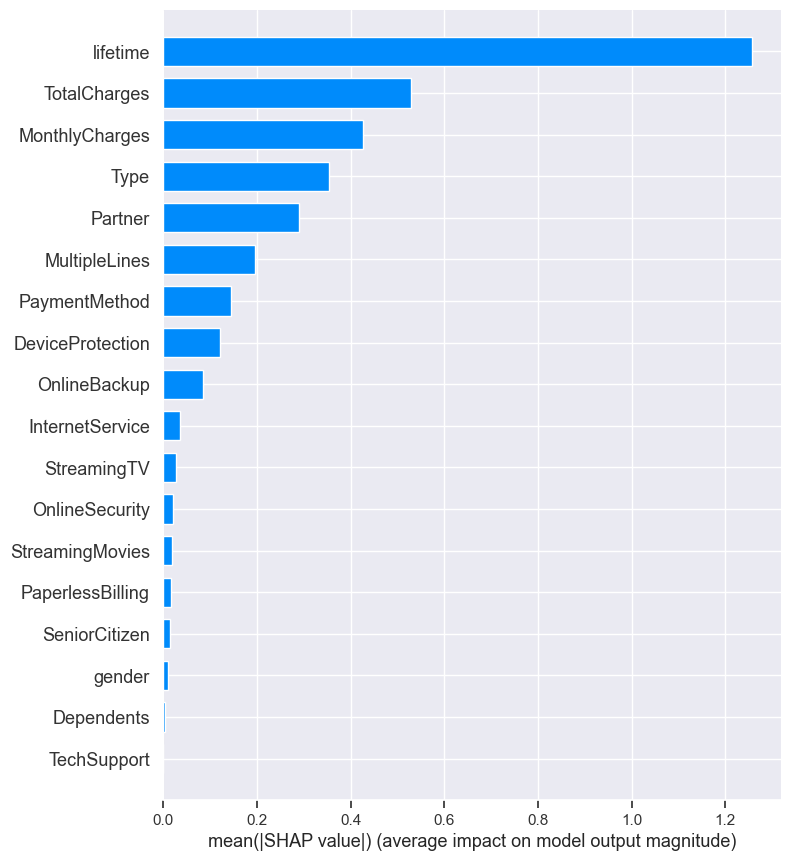

In [167]:
shap.summary_plot(shap_values_train, X_train, plot_type='bar')